In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

Figure 1: PCA Plot

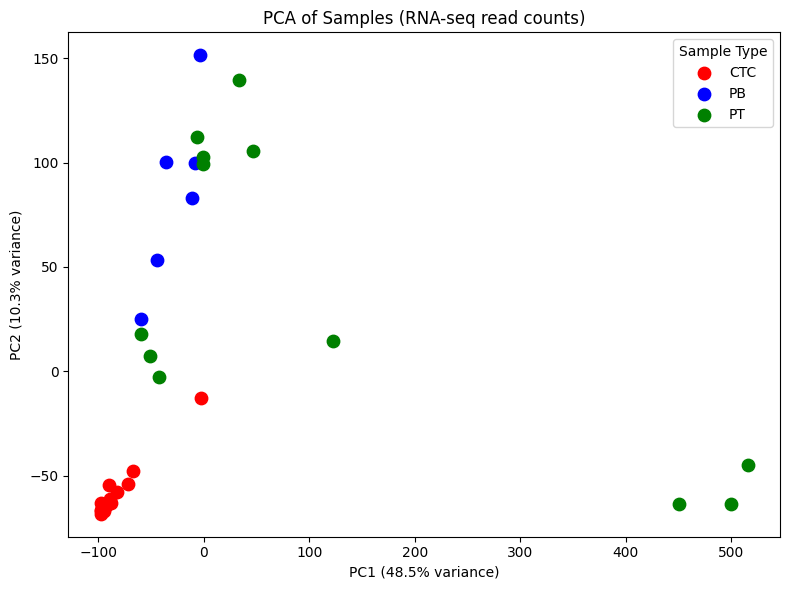

In [2]:
# 1. Load merged count matrix
df = pd.read_csv("merged_counts_matrix.txt", sep="\t")

# 2. Set gene column as index
df = df.set_index("gene")

# 3. Log-transform counts (avoid log(0))
log_df = np.log2(df + 1)

# 4. Standardize features (genes)
scaler = StandardScaler()
scaled = scaler.fit_transform(log_df.T)  # transpose: samples as rows

# 5. Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

# 6. Extract sample names
samples = log_df.columns

# 7. Assign groups based on the first part of the name
groups = [s.split("_")[0] for s in samples]

# Rename groups: BLOOD -> PB, TUMOR -> PT
groups = ["PB" if g == "BLOOD" else "PT" if g == "TUMOR" else g for g in groups]

# 8. Create PCA DataFrame
pca_df = pd.DataFrame({
    "PC1": pca_result[:,0],
    "PC2": pca_result[:,1],
    "sample": samples,
    "group": groups
})

# 9. Define color map for groups
color_map = {
    "CTC": "red",
    "PB": "blue",
    "PT": "green"
}

# Assign colors for plotting
colors = [color_map[g] for g in pca_df["group"]]

# 10. Plot PCA
plt.figure(figsize=(8,6))

for group in sorted(pca_df["group"].unique()):
    subset = pca_df[pca_df["group"] == group]
    plt.scatter(subset["PC1"], subset["PC2"],
                color=color_map[group], label=group, s=80)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("PCA of Samples (RNA-seq read counts)")
plt.legend(title="Sample Type")
plt.tight_layout()
plt.savefig('pca.png')
plt.show()

**Run the DGE R Script First Before the Next Figure**

Figure 2: Differential Gene Expression Volcano Plot

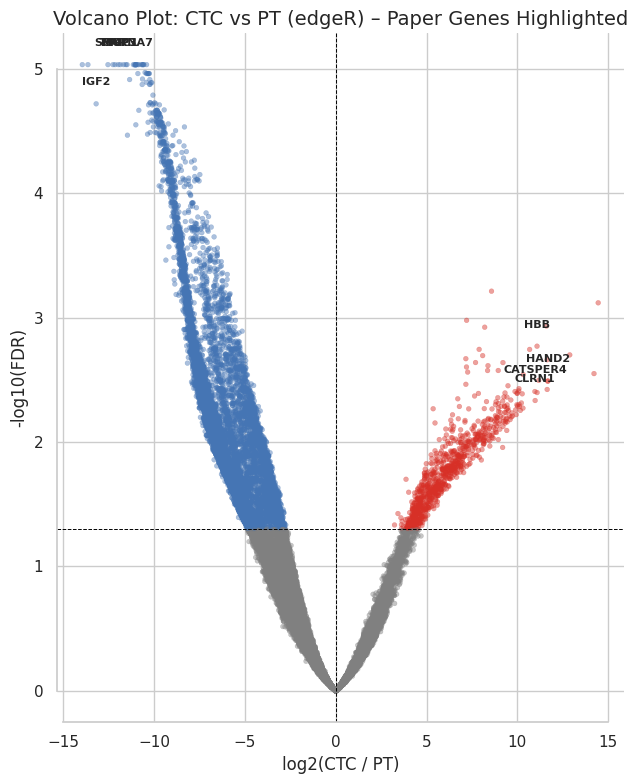

           gene  log2FoldChange      padj regulation  significant
2125      TIMP3      -11.969449  0.000009   Up in PT         True
3662        MGP      -12.143827  0.000009   Up in PT         True
10283     CLRN1       10.977748  0.004640  Up in CTC         True
10431     HAND2       11.688436  0.003232  Up in CTC         True
11165      IGF2      -13.185926  0.000019   Up in PT         True
14217      MUC1      -11.855539  0.000009   Up in PT         True
14784  CATSPER4       10.964583  0.003928  Up in CTC         True
19388   SCARNA7      -11.679161  0.000009   Up in PT         True
19833       HBB       11.081909  0.001699  Up in CTC         True


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Load edgeR results with gene symbols ====
res = pd.read_csv("edgeR_all_DEGs_CTC_vs_PT_geneSymbols.txt", sep="\t")

# Rename columns to match plotting code
res = res.rename(columns={
    "logFC": "log2FoldChange",
    "FDR": "padj",
    "gene_symbol": "gene"
})

# Flip log2FoldChange to represent CTC / PT
res["log2FoldChange"] = -res["log2FoldChange"]

# Compute -log10(FDR)
res["log10padj"] = -np.log10(res["padj"])

# Categorize regulation based on CTC / PT
res["regulation"] = "NS"
res.loc[(res["log2FoldChange"] > 0) & (res["padj"] < 0.05), "regulation"] = "Up in CTC"
res.loc[(res["log2FoldChange"] < 0) & (res["padj"] < 0.05), "regulation"] = "Up in PT"

res["regulation"] = pd.Categorical(
    res["regulation"],
    categories=["Up in CTC", "NS", "Up in PT"],
    ordered=True
)

# ===========================================================
# 🔥 Label specific genes from paper
# ===========================================================
top_genes_pt_paper = ["IGF2","TIMP3","MGP","MUC1","SCARNA7"]
top_genes_ctc_paper = ["HBB","HAND2","OR52H1","CATSPER4","CLRN1"]
highlight_genes = top_genes_pt_paper + top_genes_ctc_paper

res["label"] = res["gene"].where(res["gene"].isin(highlight_genes), "")

# ===========================================================
# 🔥 Volcano Plot
# ===========================================================
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6.5, 8))

# Scatter plot
sns.scatterplot(
    data=res,
    x="log2FoldChange",
    y="log10padj",
    hue="regulation",
    palette={
        "Up in CTC": "#D73027",
        "NS": "gray",
        "Up in PT": "#4575B4"
    },
    alpha=0.45,
    s=12,
    edgecolor=None,
    legend=False
)

# Threshold lines
plt.axvline(x=0, linestyle="--", color="black", linewidth=0.7)
plt.axhline(y=-np.log10(0.05), linestyle="--", color="black", linewidth=0.7)

# Add labels for selected genes
label_df = res[res["label"] != ""]
for _, row in label_df.iterrows():
    plt.text(
        row["log2FoldChange"],
        row["log10padj"] + 0.15,
        row["label"],
        fontsize=8,
        ha="center",
        fontweight="bold"
    )

# Axis labels and title
plt.xlabel("log2(CTC / PT)", fontsize=12)
plt.ylabel("-log10(FDR)", fontsize=12)
plt.title("Volcano Plot: CTC vs PT (edgeR) – Paper Genes Highlighted", fontsize=14)

sns.despine(trim=True)
plt.tight_layout()

# Save plot
plt.savefig("volcano_plot_edgeR_CTC_vs_PT_paper_genes.png", dpi=300)
plt.savefig("volcano_plot_edgeR_CTC_vs_PT_paper_genes.pdf")
plt.show()

# ===========================================================
# 🔥 Check significance of paper genes
# ===========================================================
paper_genes = top_genes_pt_paper + top_genes_ctc_paper

paper_gene_results = res[res["gene"].isin(paper_genes)][
    ["gene", "log2FoldChange", "padj", "regulation"]
].copy()

# Add a column to check significance
paper_gene_results["significant"] = paper_gene_results["padj"] < 0.05

# Show the table
print(paper_gene_results)
